In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 15

### OpenVINO

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [4]:
import sys
import os

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from openvino.runtime import Core

from pathlib import Path

import tensorflow as tf
from IPython.display import Markdown

sys.path.append("/home/pks/01_projects/CDAC/DHPCAP/notebooks/utils")
from notebook_utils import segmentation_map_to_image

2024-06-18 08:04:16.955086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 08:04:16.955163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 08:04:16.956431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 08:04:16.961905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 08:04:17.804421: W tensorflow/compiler/tf2

In [5]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of inputs for this module
subDir = 'vino'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('..', 'vino_model')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

In [6]:
ie = Core()
ie.available_devices

['CPU', 'GPU']

In [7]:
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, 'FULL_DEVICE_NAME')
    print(f"{device}: {device_name}")

CPU: AMD Ryzen 7 5800H with Radeon Graphics         
GPU: NVIDIA GeForce RTX 3060 Laptop GPU (dGPU)


In [8]:
device = devices[1]
device

'GPU'

## Image Segmentation

A very basic introduction to using segmentation models with OpenVINO™.

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

In [9]:
ie = Core()

model = ie.read_model(model=os.path.join(modelDir, 'road-segmentation-adas-0001.xml'))
compiled_model = ie.compile_model(model=model)

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

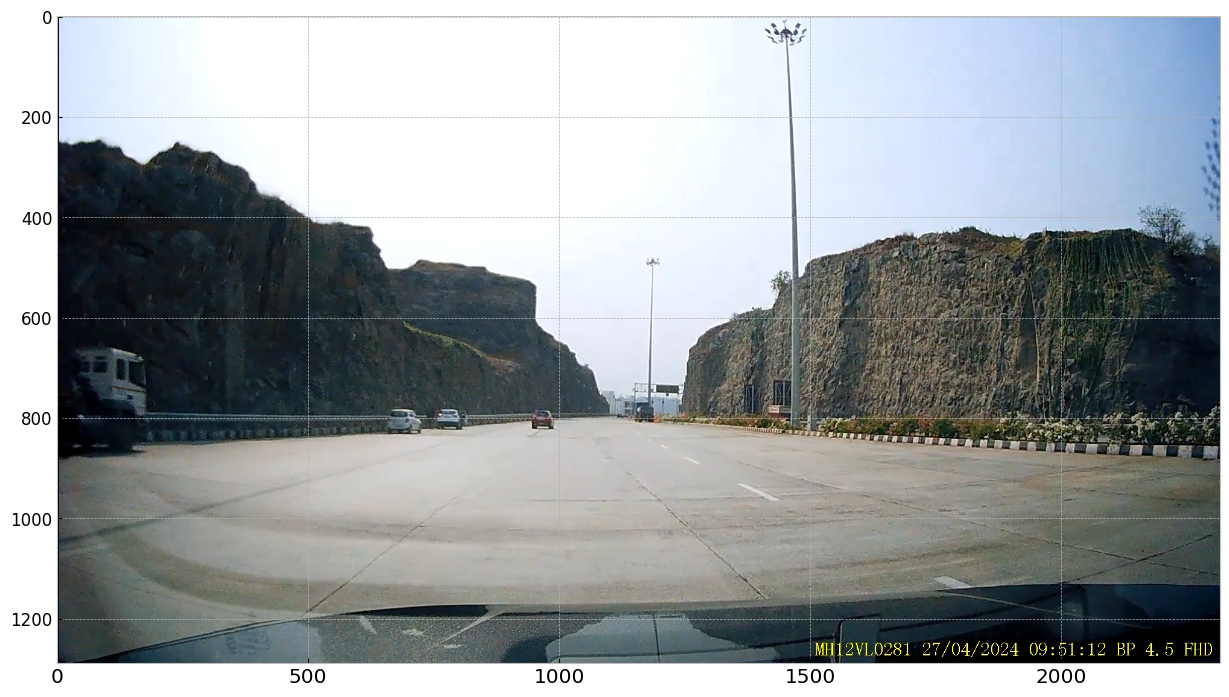

In [10]:
# The segmentation network expects images in BGR format.
image = cv2.imread(filename=os.path.join(inpDir,"basic_operations/road_2.png"))

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
N, C, H, W = input_layer_ir.shape

# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))

# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
plt.imshow(rgb_image);

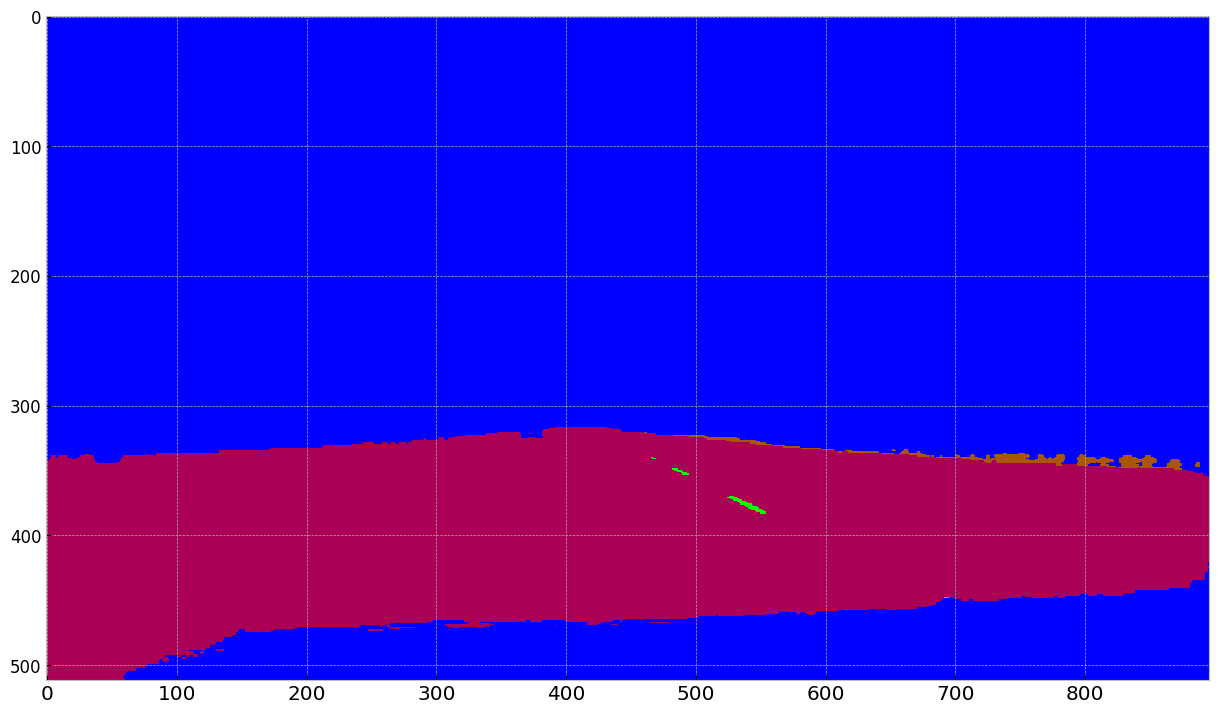

In [11]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
segmentation_mask = np.argmax(result, axis=1)
plt.imshow(segmentation_mask.transpose(1, 2, 0))

In [12]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

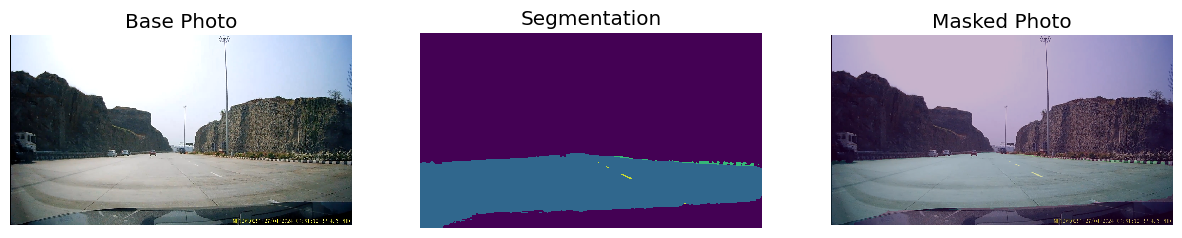

In [13]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)